In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math
import time

#plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Markdown, display
import ipywidgets as widgets
import seaborn as sns
sns.set()

#Pipelines
from source import *
import source.fairness as fm
import source.pipes as op

#Sampling
from sklearn.model_selection import train_test_split

#Storing trains
import pickle

In [2]:
#Run following codes for loading pipelines on dictionary from pickles
with open('pipes/causal_2sem/preprocessing.pickle', 'rb') as f:
    preprocessing_pickles = pickle.load(f)
    
with open('pipes/causal_2sem/y.pickle', 'rb') as f:
    y = pickle.load(f)
    
with open('pipes/causal_2sem/preprocessing_test.pickle', 'rb') as f:
    data_test_prepro = pickle.load(f)
    
with open('pipes/causal_2sem/A.pickle', 'rb') as f:
    A = pickle.load(f)
    
with open('pipes/causal_2sem/preprocessing_features_aware.pickle', 'rb') as f:
    aware_features = pickle.load(f)

with open('pipes/causal_2sem/preprocessing_features_gender.pickle', 'rb') as f:
    gender_features = pickle.load(f)

with open('pipes/causal_2sem/preprocessing_features_public_school.pickle', 'rb') as f:
    public_school_features = pickle.load(f)


In [3]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
#remember: transf means data normalized and scaled.
datasets_prepro = {}
pipes_nominal = {}
pipes_numerical = {}

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    y_train = y['train']
    y_test = y['test']
    
for Aval in A:
    A_train = A['train']
    A_test = A['test']

# Model Train Pipes

Using the prepared train datasets, different model will be training in order to identify the get the best model considering different set of parameters.

Let define the use of the different dataset

In [4]:
#Get in a dictionary all preprocessed datasets.
datasets = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets['transformed_'+d] = ds

In [5]:
datasets.keys()

dict_keys(['transformed_aware', 'transformed_gender', 'transformed_public_school'])

### Train Classifiers

In [6]:
#Defining Models and parameters for gid
#Random Forest
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

rf_res = {}

for ds in datasets:
    print("Starting for..."+ds+' with '+str(datasets[ds].shape)+' features')
    X = datasets[ds].toarray()
    y_train_data = y_train
        
    fit = op.get_grid(X, y_train_data, parameters, rf, 'RF')
    print("End for "+ds)
    print()
    
    rf_res[ds] = fit

Starting for...transformed_aware with (3294, 44) features
End for transformed_aware

Starting for...transformed_gender with (3294, 43) features
End for transformed_gender

Starting for...transformed_public_school with (3294, 43) features
End for transformed_public_school



In [7]:
#Random classifier
parameters = {'dummy__strategy': ['uniform']}
dummy = DummyClassifier()

dummy_res = {}

for ds in datasets:
    print("Starting for..."+ds+' with '+str(datasets[ds].shape)+' features')
    X = datasets[ds].toarray()
    y_train_data = y_train
        
    fit = op.get_grid(X, y_train_data, parameters, dummy, 'dummy')
    print("End for "+ds)
    print()
    
    dummy_res[ds] = fit

Starting for...transformed_aware with (3294, 44) features
End for transformed_aware

Starting for...transformed_gender with (3294, 43) features
End for transformed_gender

Starting for...transformed_public_school with (3294, 43) features
End for transformed_public_school



In [8]:
train_models = {'RF':rf_res, 'dummy': dummy_res}

In [9]:
#Run this code for storing grid results
with open('grid/causal_2sem/train_models.pickle', 'wb') as f:
    pickle.dump(train_models, f)

In [10]:
#Run this code for loading models
with open('grid/causal_2sem/train_models.pickle', 'rb') as f:
    train_models = pickle.load(f)

In [11]:
train_models.keys()

dict_keys(['RF', 'dummy'])

# Comparing Results with test
After training and getting the better results for each dataset, now we analyze the differences for each model by using the data tests.

Now, the process of prediction is apply using the "best" model for each trained model.

In [12]:
#Get in a dictionary all preprocessed datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test['transformed_'+d] = ds
datasets_test.keys()


dict_keys(['transformed_aware', 'transformed_gender', 'transformed_public_school'])

Now, we apply the prediction for each model and datasets in order to evaluate how the models perform between groups.

In [13]:
results_test_complete = pd.DataFrame(columns = ['model', 'scenario', 'f1_score', 'f1_score_priv','f1_score_unpriv','accuracy', 'accuracy_priv','accuracy_unpriv', 'auc', 'auc_priv', 'auc_unpriv'])
results_test = pd.DataFrame(columns = ['model', 'dataset', 'unaware', 'f1_score', 'accuracy_score', 'auc'])
results_per_group_gender = pd.DataFrame(columns = ['model', 'dataset', 'unaware', 'f1_score', 'f1_score_priv','f1_score_unpriv', 'accuracy','accuracy_priv','accuracy_unpriv', 'auc', 'auc_priv', 'auc_unpriv'])
results_per_group_school = pd.DataFrame(columns = ['model', 'dataset', 'unaware', 'f1_score',  'f1_score_priv','f1_score_unpriv', 'accuracy','accuracy_priv','accuracy_unpriv', 'auc','auc_priv', 'auc_unpriv'])

for m in train_models:
    #get grid of a specific model
    grid_model = train_models[m]
    print()
    print('Running for {0} model:'.format(m))
    
    #predict for each dataset
    for ds in datasets_test:
        if not('original' in ds):
            print("  Evaluating for {0} datasets...".format(ds))
            unaware = 0
            
            ds_test = datasets_test[ds].toarray()
            estimator_grid = grid_model[ds].best_estimator_[m]
            y_pred = estimator_grid.predict(ds_test)
            y_pred_prob = estimator_grid.predict_proba(ds_test)[:,1]
            
            #Overall performances
            y_test_data = y_test
                
            f1 = f1_score(y_test_data, y_pred)
            auc = roc_auc_score(y_test_data, y_pred_prob)
            acc = accuracy_score(y_test_data, y_pred)

            #Identifying aware, feature selection and decomposition
            if ('gender' in ds) or ('public_school' in ds): unaware = 1
        
            #Performances per group
            if ('gender' in ds) or ('aware' in ds):
                print('  Saving results for gender...')
                
                A_fairness = A_test['gender']
                
                f1_gend_f = f1_score(y_test_data[A_fairness==1], y_pred[np.where(A_fairness==1)])
                f1_gend_m = f1_score(y_test_data[A_fairness==0], y_pred[np.where(A_fairness==0)])

                auc_gend_f = roc_auc_score(y_test_data[A_fairness==1], y_pred_prob[np.where(A_fairness==1)])
                auc_gend_m = roc_auc_score(y_test_data[A_fairness==0], y_pred_prob[np.where(A_fairness==0)])

                acc_f = accuracy_score(y_test_data[A_fairness==1], y_pred[np.where(A_fairness==1)])
                acc_m = accuracy_score(y_test_data[A_fairness==0], y_pred[np.where(A_fairness==0)])

                r_gender = {'model': m, 'dataset':ds, 'unaware': unaware,'f1_score': f1, 'f1_score_priv':f1_gend_m, 'f1_score_unpriv':f1_gend_f, 'accuracy':acc ,'accuracy_priv': acc_m,'accuracy_unpriv':acc_f , 'auc': auc, 'auc_priv': auc_gend_m, 'auc_unpriv': auc_gend_f}
                results_per_group_gender = results_per_group_gender.append(r_gender, ignore_index = True)


            if ('school' in ds) or ('aware' in ds):
                print('  Saving results for school...')
                
                A_fairness = A_test['public_school']
                
                f1_gend_p = f1_score(y_test_data[A_fairness==1], y_pred[np.where(A_fairness==1)])
                f1_gend_np = f1_score(y_test_data[A_fairness==0], y_pred[np.where(A_fairness==0)])

                auc_gend_p = roc_auc_score(y_test_data[A_fairness==1], y_pred_prob[np.where(A_fairness==1)])
                auc_gend_np = roc_auc_score(y_test_data[A_fairness==0], y_pred_prob[np.where(A_fairness==0)])

                acc_p = accuracy_score(y_test_data[A_fairness==1], y_pred[np.where(A_fairness==1)])
                acc_np = accuracy_score(y_test_data[A_fairness==0], y_pred[np.where(A_fairness==0)])
                                                                                                                                                                                                                                                                                          
                r_school = {'model': m, 'dataset':ds, 'unaware': unaware, 'f1_score': f1, 'f1_score_priv': f1_gend_np, 'f1_score_unpriv':f1_gend_p, 'accuracy':acc ,'accuracy_priv':acc_np ,'accuracy_unpriv': acc_p, 'auc': auc, 'auc_priv': auc_gend_np, 'auc_unpriv': auc_gend_p}
                results_per_group_school = results_per_group_school.append(r_school, ignore_index = True)

            if 'transformed' in ds and ('gender' in ds or 'school' in ds):
                scenario=''
                if 'gender' in ds:
                    scenario = 'gender'
                    f1_priv = f1_gend_m
                    f1_unpriv = f1_gend_f
                    acc_priv = acc_m
                    acc_unpriv = acc_f
                    auc_priv = auc_gend_m
                    auc_unpriv = auc_gend_f
                elif 'school' in ds:
                    scenario = 'public_school'
                    f1_priv = f1_gend_np
                    f1_unpriv = f1_gend_p
                    acc_priv = acc_np
                    acc_unpriv = acc_p
                    auc_priv = auc_gend_np
                    auc_unpriv = auc_gend_p
                                                                                                                                                                                                                         
                r_complete = {'model': m, 'scenario': scenario, 'f1_score': f1, 'f1_score_priv': f1_priv,'f1_score_unpriv': f1_unpriv,'accuracy': acc,'accuracy_priv': acc_priv,'accuracy_unpriv': acc_unpriv, 'auc': auc, 'auc_priv': auc_priv, 'auc_unpriv':auc_unpriv}
                results_test_complete = results_test_complete.append(r_complete, ignore_index = True)

            r = {'model': m, 'dataset': ds, 'unaware': unaware, 'f1_score': f1, 'accuracy_score': acc, 'auc': auc}
            results_test = results_test.append(r, ignore_index = True)


Running for RF model:
  Evaluating for transformed_aware datasets...
  Saving results for gender...
  Saving results for school...
  Evaluating for transformed_gender datasets...
  Saving results for gender...
  Evaluating for transformed_public_school datasets...
  Saving results for school...

Running for dummy model:
  Evaluating for transformed_aware datasets...
  Saving results for gender...
  Saving results for school...
  Evaluating for transformed_gender datasets...
  Saving results for gender...
  Evaluating for transformed_public_school datasets...
  Saving results for school...


In [15]:
#These pickles are for storing the results.
with open('results/causal_2sem/results_test.pickle', 'wb') as f:
    pickle.dump(results_test_complete, f)
    
with open('results/causal_2sem/results_per_group_gender.pickle', 'wb') as f:
    pickle.dump(results_per_group_gender, f)
    
with open('results/causal_2sem/results_per_group_school.pickle', 'wb') as f:
    pickle.dump(results_per_group_school, f)

In [16]:
#Run the following codes for open pickles
with open('results/causal_2sem/results_test.pickle', 'rb') as f:
    results_test = pickle.load(f)

with open('results/causal_2sem/results_per_group_gender.pickle', 'rb') as f:
    results_per_group_gender = pickle.load(f)
    
with open('results/causal_2sem/results_per_group_school.pickle', 'rb') as f:
    results_per_group_school = pickle.load(f)

In [17]:
results_per_group_school.loc[results_per_group_school['unaware']==0,:].sort_values(by='f1_score', ascending=False)

,model,dataset,unaware,f1_score,f1_score_priv,f1_score_unpriv,accuracy,accuracy_priv,accuracy_unpriv,auc,auc_priv,auc_unpriv
0,RF,transformed_aware,0,0.436508,0.439437,0.429530,0.798867,0.819583,0.724919,0.884841,0.894885,0.845074
2,dummy,transformed_aware,0,0.180139,0.162896,0.236453,0.497167,0.496827,0.498382,0.500000,0.500000,0.500000


In [18]:
results_per_group_school.loc[results_per_group_school['unaware']==0,:].sort_values(by='f1_score', ascending=False)

,model,dataset,unaware,f1_score,f1_score_priv,f1_score_unpriv,accuracy,accuracy_priv,accuracy_unpriv,auc,auc_priv,auc_unpriv
0,RF,transformed_aware,0,0.436508,0.439437,0.429530,0.798867,0.819583,0.724919,0.884841,0.894885,0.845074
2,dummy,transformed_aware,0,0.180139,0.162896,0.236453,0.497167,0.496827,0.498382,0.500000,0.500000,0.500000


In [19]:
results_per_group_gender.loc[results_per_group_school['unaware']==0,:].sort_values(by='f1_score', ascending=False)

,model,dataset,unaware,f1_score,f1_score_priv,f1_score_unpriv,accuracy,accuracy_priv,accuracy_unpriv,auc,auc_priv,auc_unpriv
0,RF,transformed_aware,0,0.436508,0.401361,0.485714,0.798867,0.791716,0.809524,0.884841,0.863963,0.912852
2,dummy,transformed_aware,0,0.180139,0.190476,0.165746,0.497167,0.517160,0.467372,0.500000,0.500000,0.500000


In [21]:
results_per_group_gender.loc[results_per_group_school['unaware']==1,:].sort_values(by='f1_score', ascending=False)

,model,dataset,unaware,f1_score,f1_score_priv,f1_score_unpriv,accuracy,accuracy_priv,accuracy_unpriv,auc,auc_priv,auc_unpriv
1,RF,transformed_gender,1,0.452471,0.405063,0.523810,0.796034,0.777515,0.823633,0.8953,0.870807,0.926498
3,dummy,transformed_gender,1,0.180708,0.163090,0.203966,0.524788,0.538462,0.504409,0.5000,0.500000,0.500000


# Fairness Metrics
Let measure the fairness metrics for each model. 

In [22]:
results_fairness_gender = pd.DataFrame(columns = ['model', 'dataset', 'fairness_mitigation', 'f1', 'accuracy', 'auc', 'demographic_parity_dif', 'disparate_impact_rate', 'equal_opp_dif', 'equalized_odd_dif', 'sufficiency_dif'])
results_fairness_school = pd.DataFrame(columns = ['model', 'dataset', 'fairness_mitigation', 'f1', 'accuracy', 'auc','demographic_parity_dif', 'disparate_impact_rate', 'equal_opp_dif', 'equalized_odd_dif', 'sufficiency_dif'])

#Let call fairness_mitigation to: awarnessed, not awarnessed (not explicit only), feature selection, decomposition, decomposition and feature selection
#Note: only awarnessed assumes explicit sensitive attriutbes

#For truth ground we use y_test

#Get train datasets and sensitive attributes
for m in train_models:
    #get grid of a specific model
    grid_model = train_models[m]
    print()
    print('Running for {0} model:'.format(m))
    
    for ds in datasets_test:
        print("  Evaluating for {0} datasets...".format(ds))
        ds_test = datasets_test[ds].toarray()
        estimator_grid = grid_model[ds].best_estimator_[m]

        #Identify sensitive attribute
        gender = 0
        school = 0
        if ('gender' in ds) or ('aware' in ds):
            gender = 1
        if ('school' in ds) or ('aware' in ds):
            school = 1
                
        #Identify fairness mitigation
        fairness_mitigation = ''
        if 'aware' in ds:
            fairness_mitigation = 'aware'
        else:
            fairness_mitigation = 'unaware'

        #Get Prediction
        y_test_data = y_test
                
        prediction = estimator_grid.predict(ds_test)

        #Getting Overall performances #Overall performances
        f1 = f1_score(y_test_data, prediction)
        auc = roc_auc_score(y_test_data, estimator_grid.predict_proba(ds_test)[:,1])
        acc = accuracy_score(y_test_data, prediction)

        #Evaluate Fairness metrics.
        #Let asume we are evaluating based on demographic_parity_dif
        if school == 1:
            sens = A_test['public_school']
            fairness_perfo_dpd = fm.demographic_parity_dif(prediction, sens, 0)
            fairness_perfo_di = fm.disparate_impact_rate(prediction, sens, 0)-1
            fairness_perfo_eopd = fm.equal_opp_dif(y_test_data, prediction, sens, 0)
            fairness_perfo_eod = fm.equalized_odd_dif(y_test_data, prediction, sens, 0)
            fairness_perfo_suff_dif = fm.sufficiency_dif(y_test_data, prediction, sens, 0)

            new_res = {'model': m, 'dataset':ds, 'fairness_mitigation':fairness_mitigation, 'f1':f1, 'accuracy':acc, 'auc':auc, 'demographic_parity_dif':fairness_perfo_dpd, 'disparate_impact_rate':fairness_perfo_di, 'equal_opp_dif':fairness_perfo_eopd, 'equalized_odd_dif':fairness_perfo_eod, 'sufficiency_dif':fairness_perfo_suff_dif}
            results_fairness_school=results_fairness_school.append(new_res, ignore_index=True)
            
        if gender == 1:
            sens = A_test['gender']
            fairness_perfo_dpd = fm.demographic_parity_dif(prediction, sens, 0)
            fairness_perfo_di = fm.disparate_impact_rate(prediction, sens, 0)-1
            fairness_perfo_eopd = fm.equal_opp_dif(y_test_data, prediction, sens, 0)
            fairness_perfo_eod = fm.equalized_odd_dif(y_test_data, prediction, sens,0)
            fairness_perfo_suff_dif = fm.sufficiency_dif(y_test_data, prediction, sens, 0)

            new_res = {'model': m, 'dataset':ds, 'fairness_mitigation':fairness_mitigation, 'f1':f1, 'accuracy':acc, 'auc':auc, 'demographic_parity_dif':fairness_perfo_dpd, 'disparate_impact_rate':fairness_perfo_di, 'equal_opp_dif':fairness_perfo_eopd, 'equalized_odd_dif':fairness_perfo_eod, 'sufficiency_dif':fairness_perfo_suff_dif}
            results_fairness_gender=results_fairness_gender.append(new_res, ignore_index=True)


Running for RF model:
  Evaluating for transformed_aware datasets...
  Evaluating for transformed_gender datasets...
  Evaluating for transformed_public_school datasets...

Running for dummy model:
  Evaluating for transformed_aware datasets...
  Evaluating for transformed_gender datasets...
  Evaluating for transformed_public_school datasets...


In [23]:
fairness_results = {'school': results_fairness_school,
                   'gender': results_fairness_gender}

In [24]:
#This pickles are for storing the results.
with open('results/causal_2sem/fairness_results.pickle', 'wb') as f:
    pickle.dump(fairness_results, f)

In [25]:
#Run the following for open pickles
with open('results/causal_2sem/fairness_results.pickle', 'rb') as f:
    fairness_results = pickle.load(f)
    
results_fairness_school = fairness_results['school']
results_fairness_gender = fairness_results['gender']
fairness_results = {'school': results_fairness_school,
                   'gender': results_fairness_gender}

In [26]:
results_fairness_gender.sort_values(by='f1', ascending=False)

,model,dataset,fairness_mitigation,f1,accuracy,auc,demographic_parity_dif,disparate_impact_rate,equal_opp_dif,equalized_odd_dif,sufficiency_dif
1,RF,transformed_gender,unaware,0.452471,0.796034,0.895300,-0.011793,-0.042403,0.142080,0.127260,0.091898
0,RF,transformed_aware,aware,0.436508,0.798867,0.884841,0.014243,0.056504,0.136012,0.101072,0.060753
2,dummy,transformed_aware,aware,0.180964,0.506374,0.500000,-0.022126,-0.043179,-0.071772,0.003929,-0.000631
3,dummy,transformed_gender,unaware,0.151990,0.502125,0.500000,0.003909,0.008037,-0.016112,-0.005242,0.003501


In [27]:
results_fairness_school.sort_values(by='f1', ascending=False)

,model,dataset,fairness_mitigation,f1,accuracy,auc,demographic_parity_dif,disparate_impact_rate,equal_opp_dif,equalized_odd_dif,sufficiency_dif
1,RF,transformed_public_school,unaware,0.454198,0.797450,0.893980,0.120002,0.488422,0.035,0.136755,-0.000229
0,RF,transformed_aware,aware,0.436508,0.798867,0.884841,0.121563,0.525820,0.020,0.118039,-0.012304
2,dummy,transformed_aware,aware,0.180964,0.506374,0.500000,-0.068747,-0.132567,0.000,0.024457,0.062120
3,dummy,transformed_public_school,unaware,0.147619,0.492918,0.500000,0.015797,0.032088,-0.130,-0.013200,0.000774


In [29]:
results_fairness_school.columns[[6,7,9]]

Index(['demographic_parity_dif', 'disparate_impact_rate', 'equalized_odd_dif'], dtype='object')

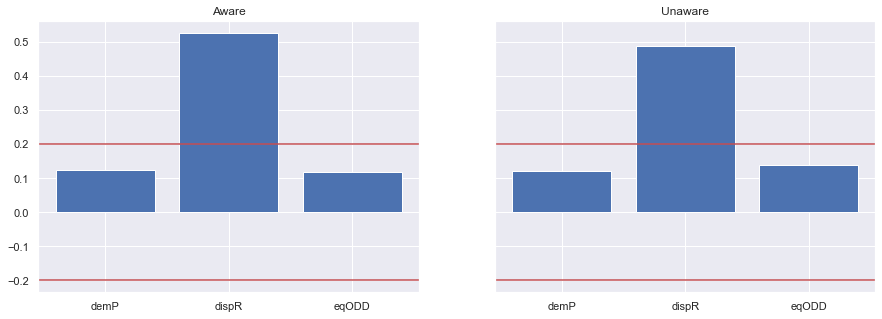

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),  sharey='row')

x = ['demP', 'dispR', 'eqODD']
height = results_fairness_school.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
ax1.bar(x, height)
ax1.set_title('Aware')
ax1.axhline(y=-.2, color = 'r')
ax1.axhline(y=.2, color=  'r')

x = ['demP', 'dispR', 'eqODD']
height = results_fairness_school.loc[[(x=='RF' and y=='unaware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
ax2.bar(x, height)
ax2.set_title('Unaware')
ax2.axhline(y=-.2, color = 'r')
ax2.axhline(y=.2, color=  'r')

plt.show()

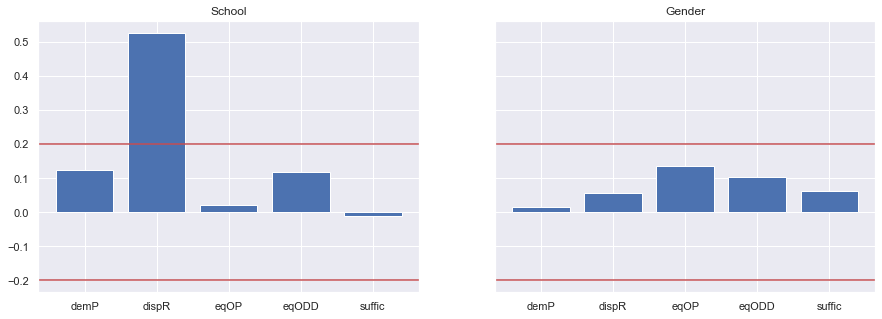

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),  sharey='row')

x = ['demP', 'dispR', 'eqOP', 'eqODD', 'suffic']
height_school = results_fairness_school.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[range(6,11)]].to_numpy().flatten()  

ax1.bar(x, height_school)
ax1.set_title('School')
ax1.axhline(y=-.2, color = 'r')
ax1.axhline(y=.2, color=  'r')

x = ['demP', 'dispR', 'eqOP', 'eqODD', 'suffic']
height_gender = results_fairness_gender.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_gender['model'], results_fairness_gender['fairness_mitigation']))],results_fairness_gender.columns[range(6,11)]].to_numpy().flatten()  
ax2.bar(x, height_gender)
ax2.set_title('Gender')
ax2.axhline(y=-.2, color = 'r')
ax2.axhline(y=.2, color=  'r')

plt.show()

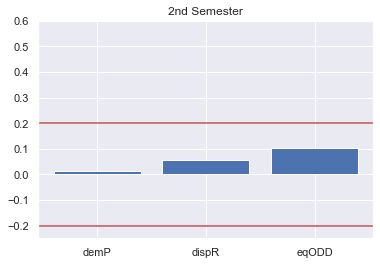

In [33]:
height_school = results_fairness_gender.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_gender['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
x = ['demP', 'dispR', 'eqODD']

plt.bar(x, height_school)
plt.title('2nd Semester')
plt.ylim([-.25,.6])
plt.axhline(y=-.2, color = 'r')
plt.axhline(y=.2, color=  'r')
plt.show()

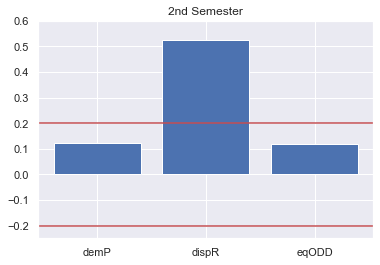

In [34]:
height_school = results_fairness_school.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
x = ['demP', 'dispR', 'eqODD']


plt.bar(x, height_school)
plt.title('2nd Semester')
plt.ylim([-.25,.6])
plt.axhline(y=-.2, color = 'r')
plt.axhline(y=.2, color=  'r')
plt.show()

# Implementing Pre-processing Fairness Mitigation

In [36]:
aware_features.extend(['label'])

In [38]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from tqdm import tqdm

features_pd = pd.DataFrame(aware_features)
ds_train = pd.DataFrame(datasets['transformed_aware'].toarray(), index=y_train.index)
ds_train = pd.concat([ds_train, y_train], axis=1, ignore_index=False)
ds_train.columns = aware_features

ds_test = pd.DataFrame(datasets_test['transformed_aware'].toarray(), index=y_test.index)
ds_test = pd.concat([ds_test, y_test], axis=1, ignore_index=False)
ds_test.columns = aware_features


train = BinaryLabelDataset(df=ds_train, favorable_label = 1, unfavorable_label = 0, label_names = ['label'], protected_attribute_names = ['public_school_1'], unprivileged_protected_attributes = [[2.4030100227877655]], privileged_protected_attributes = [[0.]])
test = BinaryLabelDataset(df=ds_test, favorable_label = 1, unfavorable_label = 0, label_names = ['label'], protected_attribute_names = ['public_school_1'], unprivileged_protected_attributes = [[2.4030100227877655]], privileged_protected_attributes = [[0.]])
y_train_data = y_train
index_train = train.feature_names.index('public_school_1')
index_test = test.feature_names.index('public_school_1')


In [39]:
rf = train_models['RF']['transformed_aware'].best_estimator_['RF']

DIs = []
for level in tqdm(np.linspace(0., 1., 41)):
    di = DisparateImpactRemover(repair_level=level, sensitive_attribute='public_school_1' )
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    
    X_tr = np.delete(train_repd.features, index_train, axis=1)
    X_te = np.delete(test_repd.features, index_test, axis=1)
    y_tr = train_repd.labels.ravel()
    
    fit = rf.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = fit.predict(X_te)

    p = [{'public_school_1':0}]
    u = [{'public_school_1':2.4030100227877655}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups = u)
    DIs.append(cm.disparate_impact()-1)

100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


Text(0.5, 0, 'Repair Level')

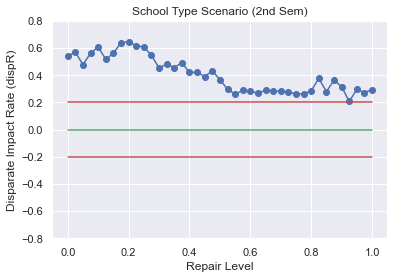

In [40]:
plt.plot(np.linspace(0, 1, 41), DIs, marker='o')
plt.plot([0, 1], [0, 0], 'g')
plt.plot([0, 1], [-0.2, -0.2], 'r')
plt.plot([0, 1], [0.2, 0.2], 'r')
plt.ylim([-0.8, 0.8])
plt.title('School Type Scenario (2nd Sem)')
plt.ylabel('Disparate Impact Rate (dispR)')
plt.xlabel('Repair Level')


In [41]:
di = DisparateImpactRemover(repair_level=np.linspace(0., 1., 41)[np.where(DIs==min(DIs))[0][0]], sensitive_attribute='public_school_1' )
rf = train_models['RF']['transformed_aware'].best_estimator_['RF']  

train_repd = di.fit_transform(train)
test_repd = di.fit_transform(test)  
    
X_tr = np.delete(train_repd.features, index_train, axis=1)
X_te = np.delete(test_repd.features, index_test, axis=1)
y_tr = train_repd.labels.ravel()
    
    
fit = rf.fit(X_tr, y_tr)
    
test_repd_pred = test_repd.copy()
test_repd_pred.labels = rf.predict(X_te)

prediction = test_repd_pred.labels
sens = A_test['public_school']
y_test_data = test_repd.labels.ravel()

fairness_perfo_dpd = fm.demographic_parity_dif(prediction, sens, 0)
fairness_perfo_di = fm.disparate_impact_rate(prediction, sens, 0)-1
fairness_perfo_eopd = fm.equal_opp_dif(y_test_data, prediction, sens, 0)
fairness_perfo_eod = fm.equalized_odd_dif(y_test_data, prediction, sens,0)
fairness_perfo_suff_dif = fm.sufficiency_dif(y_test_data, prediction, sens, 0)

f1 = f1_score(y_test_data, prediction)
auc = roc_auc_score(y_test_data, rf.predict_proba(X_te)[:,1])
acc = accuracy_score(y_test_data, prediction)

new_res = {'model': 'RF', 'dataset': 'transformed_aware', 'fairness_mitigation': 'DisparateImpactRemover', 'f1':f1, 'accuracy':acc, 'auc':auc, 'demographic_parity_dif':fairness_perfo_dpd, 'disparate_impact_rate':fairness_perfo_di, 'equal_opp_dif':fairness_perfo_eopd, 'equalized_odd_dif':fairness_perfo_eod, 'sufficiency_dif':fairness_perfo_suff_dif}
results_fairness_school=results_fairness_school.append(new_res, ignore_index=True)
results_fairness_school.sort_values(by='model', ascending=False)

,model,dataset,fairness_mitigation,f1,accuracy,auc,demographic_parity_dif,disparate_impact_rate,equal_opp_dif,equalized_odd_dif,sufficiency_dif
2,dummy,transformed_aware,aware,0.180964,0.506374,0.500000,-0.068747,-0.132567,0.000,0.024457,0.062120
3,dummy,transformed_public_school,unaware,0.147619,0.492918,0.500000,0.015797,0.032088,-0.130,-0.013200,0.000774
0,RF,transformed_aware,aware,0.436508,0.798867,0.884841,0.121563,0.525820,0.020,0.118039,-0.012304
1,RF,transformed_public_school,unaware,0.454198,0.797450,0.893980,0.120002,0.488422,0.035,0.136755,-0.000229
4,RF,transformed_aware,DisparateImpactRemover,0.453125,0.801700,0.882148,0.052167,0.206980,-0.005,0.118532,0.052503


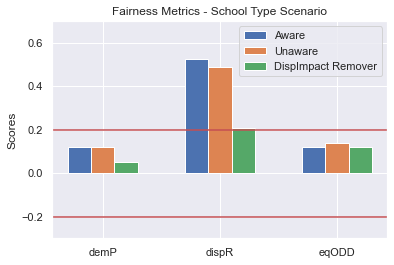

In [42]:
labels = ['demP', 'dispR', 'eqODD']
x = np.arange(len(labels))  # the label locations
width = .2  # the width of the bars
height_aware = results_fairness_school.loc[[(x=='RF' and y=='aware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
height_unaware = results_fairness_school.loc[[(x=='RF' and y=='unaware') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  
height_dimpr = results_fairness_school.loc[[(x=='RF' and y=='DisparateImpactRemover') for x,y in list(zip(results_fairness_school['model'], results_fairness_school['fairness_mitigation']))],results_fairness_school.columns[[6,7,9]]].to_numpy().flatten()  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, height_aware, width, label='Aware')
rects2 = ax.bar(x, height_unaware, width, label='Unaware')
rects3 = ax.bar(x + width, height_dimpr, width, label='DispImpact Remover')

ax.axhline(y=-.2, color = 'r')
ax.axhline(y=.2, color=  'r')
ax.set_ylim([-.3, 0.7])

ax.set_ylabel('Scores')
ax.set_title('Fairness Metrics - School Type Scenario')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# Feature Importance

In [46]:
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

In [47]:
importances = pd.DataFrame(importances, columns = ['importance'], index=train_repd.feature_names[:43])
std = pd.DataFrame(std, columns = ['std'], index=train_repd.feature_names[:43])
forest_importances = pd.concat([importances, std], axis = 1)

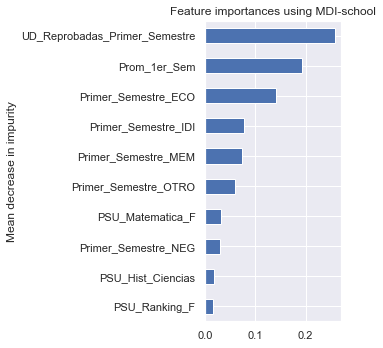

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
forest_importances.sort_values(by='importance', ascending=True)['importance'][33:].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI-school")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()